In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Dense, LSTM, Reshape


In [11]:
# Load the data
%store -r train_data_selected 

# Load the lists
%store -r selected_features
%store -r target_col

In [12]:
# Split ratio for training and testing
split_ratio = 0.8

# Initialize empty lists to store dataframes for training and testing
train_data = []
test_data = []

# Get unique simulation IDs
unique_sim_ids = train_data_selected['sim_ID'].unique()

# Loop through unique simulation IDs and split each simulation
for sim_id in unique_sim_ids:
    sim_data = train_data_selected[train_data_selected['sim_ID'] == sim_id]
    sim_data = sim_data[selected_features]  # Select only the relevant features
    
    # Calculate the split index
    split_index = int(len(sim_data) * split_ratio)
    
    # Split the simulation data into training and testing
    train_sim_data = sim_data.iloc[:split_index]
    test_sim_data = sim_data.iloc[split_index:]
    
    # Append the split data to the respective lists
    train_data.append(train_sim_data)
    test_data.append(test_sim_data)

# Concatenate the dataframes in the lists to create a single dataframe for training and testing
train_data_df = pd.concat(train_data, ignore_index=True)
test_data_df = pd.concat(test_data, ignore_index=True)

In [19]:
# def prepare_data(sim_data, input_timesteps, output_timesteps, target_col):
#     X, y = [], []
#     for i in range(len(sim_data) - input_timesteps - output_timesteps + 1):
#         X.append(sim_data.iloc[i:i + input_timesteps].values)
#         y.append(sim_data.iloc[i + input_timesteps:i + input_timesteps + output_timesteps][target_col].values)
#     return np.array(X), np.array(y)

# def create_lstm_model(input_timesteps, num_features, output_timesteps):
#     model = Sequential()
#     model.add(LSTM(units=50, activation='relu', input_shape=(input_timesteps, num_features)))
#     model.add(Dense(output_timesteps))
#     model.compile(optimizer='adam', loss='mse')
#     return model

def prepare_data(sim_data, input_timesteps, output_timesteps, target_col):
    X, y = [], []
    for i in range(len(sim_data) - input_timesteps - output_timesteps + 1):
        X.append(sim_data.iloc[i:i + input_timesteps].values)
        y_values = sim_data.iloc[i + input_timesteps:i + input_timesteps + output_timesteps][target_col].values
        y.append(np.column_stack([y_values] * num_features))  # Repeat the target values for each feature
    return np.array(X), np.array(y)

def create_lstm_model(input_timesteps, num_features, output_timesteps):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(input_timesteps, num_features), return_sequences=True))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(num_features * output_timesteps))
    model.add(Reshape((output_timesteps, num_features)))  # Reshape the output to match input shape
    model.compile(optimizer='adam', loss='mse')
    return model


def plot_training_history(history):
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper right')
    plt.show()
    
def plot_actual_vs_predicted(X_test, y_test, model):
    y_pred = model.predict(X_test)
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('Actual vs Predicted')
    plt.ylabel('Value')
    plt.xlabel('Timestep')
    plt.legend(loc='upper right')
    plt.show()

In [20]:
input_timesteps = 100
output_timesteps = 500

num_features = len(selected_features)

%store input_timesteps
%store num_features

Stored 'input_timesteps' (int)
Stored 'num_features' (int)


Epoch 1/10
52/53 [============================>.] - ETA: 0s - loss: 0.1605
Epoch 1: loss improved from inf to 0.15909, saving model to model_checkpoint.h5
53/53 [==============================] - 4s 40ms/step - loss: 0.1591
Epoch 2/10
52/53 [============================>.] - ETA: 0s - loss: 0.0169
Epoch 2: loss improved from 0.15909 to 0.01698, saving model to model_checkpoint.h5
53/53 [==============================] - 2s 42ms/step - loss: 0.0170
Epoch 3/10
53/53 [==============================] - ETA: 0s - loss: 0.0147
Epoch 3: loss improved from 0.01698 to 0.01465, saving model to model_checkpoint.h5
53/53 [==============================] - 2s 42ms/step - loss: 0.0147
Epoch 4/10
53/53 [==============================] - ETA: 0s - loss: 0.0144
Epoch 4: loss improved from 0.01465 to 0.01439, saving model to model_checkpoint.h5
53/53 [==============================] - 2s 39ms/step - loss: 0.0144
Epoch 5/10
52/53 [============================>.] - ETA: 0s - loss: 0.0143
Epoch 5: loss imp

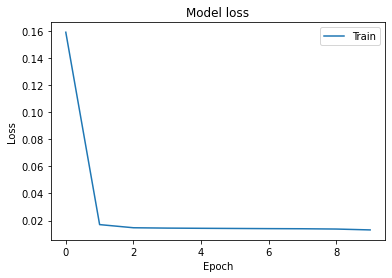

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [21]:
# Add a checkpoint system
checkpoint_filepath = "model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss', # Change this to 'val_loss' if you have validation data
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

model = create_lstm_model(input_timesteps, num_features, output_timesteps)

# Train the LSTM model on each simulation separately with the checkpoint callback
for train_sim_data in train_data:
    X_train, y_train = prepare_data(train_sim_data, input_timesteps, output_timesteps, target_col)
    history = model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1, callbacks=[checkpoint_callback])
    plot_training_history(history)

model.save("my_model.h5")

for test_sim_data in test_data:
    X_test, y_test = prepare_data(test_sim_data, input_timesteps, output_timesteps, target_col)
    plot_actual_vs_predicted(X_test, y_test, model)